In [1]:
from yggdrasil import tools  # Displaying syntax highlighted source code
from yggdrasil.runner import run  # Running integrations
import trimesh  # Load & display 3D meshes

In [2]:
tools.display_source('models/yield_v0.py', number_lines=True)

file: models/yield_v0.py
 1: import numpy as np
 2: from yggdrasil import units
 3: 
 4: 
 5: def growth_rate(t, mass, LAI):
 6:     # Compute the light intercepted
 7:     light = (LAI * units.add_units(4, 'erg/s')
 8:              * ((mass / units.add_units(2500, 'g')) ** 0.33)
 9:              * (0.5 + 0.5 * np.sin(2.0 * np.pi * np.floor(t)
10:                                    / units.add_units(1, 'yr')))
11:              * (0.5 + 0.5 * np.cos(2.0 * np.pi
12:                                    * ((t % 1.0) - units.add_units(12, 'hrs'))
13:                                    / units.add_units(1, 'day'))))
14: 
15:     # Compute the growth factor for the timestep based on the light
16:     # (pretend this is a biologically complex calculation)
17:     growth_rate = (light / units.add_units(2000.0, 'erg*day/s'))
18: 
19:     # Return output
20:     return growth_rate
21: 
22: 
23: def yield_curve(tstart, tend, tstep, mstart, LAI):
24:     t = tstart
25:     m = mstart
26:     times =

In [3]:
# from yggdrasil
# from models.yield_v0 import yield_curve
# yield_curve(80.0, 90.0, 0.1, 2000.0, 2.7)

In [4]:
tools.display_source('yamls/yield_v0.yml', number_lines=True)

file: yamls/yield_v0.yml
 1: model:
 2:   name: yield
 3:   language: python
 4:   args: ../models/yield.py
 5:   function: yield_curve
 6:   inputs:
 7:     - name: tstart
 8:       datatype:
 9:         type: float
10:         units: day
11:       default_value: 80
12:     - name: tend
13:       datatype:
14:         type: float
15:         units: day
16:       default_value: 84
17:     - name: tstep
18:       datatype:
19:         type: float
20:         units: day
21:       default_value: 0.1
22:     - name: mstart
23:       datatype:
24:         type: float
25:         units: g
26:       default_value: 2000
27:     - name: LAI
28:       datatype:
29:         type: float
30:       default_value: 2.7
31:   outputs:
32:     - name: mass
33:       default_file:
34:         name: ../output/yield.txt
35:         filetype: table
36:         as_array: true
37:         field_names: time, mass
38:         field_units: days, g



In [5]:
tools.display_source('models/light_v0.cpp', number_lines=True)

file: models/light_v0.cpp
 1: /*!
 2:   @brief Compute the intensity of light.
 3: 
 4:   @param[in] doy Day of year including partial days.
 5:   @param[in] geom 3D geometry of plant
 6:   @param[out] intensity Intensity of light in ergs s^-1.
 7: 
 8:   @returns Success (1) or failure (0).
 9:  */
10: int light(double doy, rapidjson::ObjWavefront geom,
11: 	  double* intensity) {
12:   // Define parameters that are static across a run
13:   double amplitude = 6.0e-4;
14:   double doy_offset = 0.0;
15: 
16:   // Calculate total intensity on each leaf
17:   intensity[0] = 0.0;
18:   std::vector<double> areas = geom.areas();
19:   for (std::vector<double>::iterator it = areas.begin();
20:        it != areas.end(); it++) {
21:     intensity[0] += *it * amplitude
22:       * (0.5 + 0.5 * sin(2.0 * M_PI * (floor(doy) - doy_offset) / 365))
23:       * (0.5 + 0.5 * cos(2.0 * M_PI * (std::fmod(doy, 1.0) - 0.5)));
24:   }
25: 
26:   // Return success
27:   return 1;
28: }



In [6]:
tools.display_source('yamls/light_v0.yml', number_lines=True)

file: yamls/light_v0.yml
 1: model:
 2:   name: light
 3:   language: c++
 4:   args: ../models/light_v0.cpp
 5:   function: light
 6:   inputs:
 7:     - name: doy
 8:       datatype:
 9:         type: float
10:         units: day
11:       default_value: 10.5
12:     - name: geom
13:       datatype:
14:         type: obj
15:       default_file:
16:         name: ../meshes/plants-2.obj
17:         filetype: obj
18:         count: 50
19:   output:
20:     - name: intensity
21:       datatype:
22:         type: float
23:         units: ergs/s
24:       default_file:
25:         name: ../output/light.txt
26:         filetype: table



In [7]:
tools.display_source('models/yield_v1.py', number_lines=True)

file: models/yield_v1.py
 1: import numpy as np
 2: from yggdrasil import units
 3: from yggdrasil.languages.Python.YggInterface import YggRpcClient
 4: 
 5: 
 6: def growth_rate(t, mass, LAI):
 7:     # Initialize yggdrasil connection
 8:     client = YggRpcClient("light_yield", global_scope=True)
 9:     
10:     # Compute the light intercepted
11:     flag, light = client.call(t)
12:     if not flag:
13:         raise Exception("Error calling light model")
14: 
15:     # Compute the growth factor for the timestep based on the light
16:     # (pretend this is a biologically complex calculation)
17:     growth_rate = (light / units.add_units(2000.0, 'erg*day/s'))
18: 
19:     # Return output
20:     return growth_rate
21: 
22: 
23: def yield_curve(tstart, tend, tstep, mstart, LAI):
24:     t = tstart
25:     m = mstart
26:     times = []
27:     masses = []
28:     while t < tend:
29:         growth = growth_rate(t, m, LAI)
30:         m = m + growth * m * tstep
31:         times.appe

In [8]:
tools.display_source('yamls/yield_v1.yml', number_lines=True)

file: yamls/yield_v1.yml
 1: model:
 2:   name: yield
 3:   language: python
 4:   args: ../models/yield.py
 5:   function: yield_curve
 6:   client_of: light
 7:   inputs:
 8:     - name: tstart
 9:       datatype:
10:         type: float
11:         units: day
12:       default_value: 80
13:     - name: tend
14:       datatype:
15:         type: float
16:         units: day
17:       default_value: 84
18:     - name: tstep
19:       datatype:
20:         type: float
21:         units: day
22:       default_value: 0.1
23:     - name: mstart
24:       datatype:
25:         type: float
26:         units: g
27:       default_value: 2000
28:     - name: LAI
29:       datatype:
30:         type: float
31:       default_value: 2.7
32:   outputs:
33:     - name: mass
34:       default_file:
35:         name: ../output/yield.txt
36:         filetype: table
37:         as_array: true
38:         field_names: time, mass
39:         field_units: days, g



In [9]:
tools.display_source('yamls/light_v1.yml', number_lines=True)

file: yamls/light_v1.yml
 1: model:
 2:   name: light
 3:   language: c++
 4:   args: ../models/light_v0.cpp
 5:   function: light
 6:   is_server:
 7:     input: doy
 8:     output: intensity
 9:   inputs:
10:     - name: doy
11:       datatype:
12:         type: float
13:         units: day
14:       default_value: 10.5
15:     - name: geom
16:       datatype:
17:         type: obj
18:       default_file:
19:         name: ../meshes/plants-2.obj
20:         filetype: obj
21:         count: 50
22:   output:
23:     - name: intensity
24:       datatype:
25:         type: float
26:         units: ergs/s
27:       default_file:
28:         name: ../output/light.txt
29:         filetype: table



In [10]:
tools.display_source_diff('models/yield_v0.py', 'models/yield_v1.py', number_lines=True)

file1: models/yield_v0.py
file2: models/yield_v1.py
 1:   import numpy as np
 2:   from yggdrasil import units
 3: + from yggdrasil.languages.Python.YggInterface import YggRpcClient
 4:   
 5:   
 6:   def growth_rate(t, mass, LAI):
 7: +     # Initialize yggdrasil connection
 8: +     client = YggRpcClient("light_yield", global_scope=True)
 9: +     
10:       # Compute the light intercepted
11: +     flag, light = client.call(t)
12: +     if not flag:
13: +         raise Exception("Error calling light model")
    -     light = (LAI * units.add_units(4, 'erg/s')
    -              * ((mass / units.add_units(2500, 'g')) ** 0.33)
    -              * (0.5 + 0.5 * np.sin(2.0 * np.pi * np.floor(t)
    -                                    / units.add_units(1, 'yr')))
    -              * (0.5 + 0.5 * np.cos(2.0 * np.pi
    -                                    * ((t % 1.0) - units.add_units(12, 'hrs'))
    -                                    / units.add_units(1, 'day'))))
14:   
15:       

In [11]:
tools.display_source_diff('yamls/yield_v0.yml', 'yamls/yield_v1.yml', number_lines=True)

file1: yamls/yield_v0.yml
file2: yamls/yield_v1.yml
 1:   model:
 2:     name: yield
 3:     language: python
 4:     args: ../models/yield.py
 5:     function: yield_curve
 6: +   client_of: light
 7:     inputs:
 8:       - name: tstart
 9:         datatype:
10:           type: float
11:           units: day
12:         default_value: 80
13:       - name: tend
14:         datatype:
15:           type: float
16:           units: day
17:         default_value: 84
18:       - name: tstep
19:         datatype:
20:           type: float
21:           units: day
22:         default_value: 0.1
23:       - name: mstart
24:         datatype:
25:           type: float
26:           units: g
27:         default_value: 2000
28:       - name: LAI
29:         datatype:
30:           type: float
31:         default_value: 2.7
32:     outputs:
33:       - name: mass
34:         default_file:
35:           name: ../output/yield.txt
36:           filetype: table
37:           as_array: true
38:       

In [12]:
tools.display_source_diff('yamls/light_v0.yml', 'yamls/light_v1.yml', number_lines=True)

file1: yamls/light_v0.yml
file2: yamls/light_v1.yml
 1:   model:
 2:     name: light
 3:     language: c++
 4:     args: ../models/light_v0.cpp
 5:     function: light
 6: +   is_server:
 7: +     input: doy
 8: +     output: intensity
 9:     inputs:
10:       - name: doy
11:         datatype:
12:           type: float
13:           units: day
14:         default_value: 10.5
15:       - name: geom
16:         datatype:
17:           type: obj
18:         default_file:
19:           name: ../meshes/plants-2.obj
20:           filetype: obj
21:           count: 50
22:     output:
23:       - name: intensity
24:         datatype:
25:           type: float
26:           units: ergs/s
27:         default_file:
28:           name: ../output/light.txt
29:           filetype: table



In [26]:
import os
from yggdrasil.communication.AsciiTableComm import AsciiTableComm
fname = os.path.join('output', 'yield_v0.txt')
fd = AsciiTableComm(fname, as_array=True, direction='recv')
flag, data_v0 = fd.recv()
fd.close()
fname = os.path.join('output', 'yield_v1.txt')
fd = AsciiTableComm(fname, as_array=True, direction='recv')
flag, data_v1 = fd.recv()
fd.close()

Text(0, 0.5, 'Mass (g)')

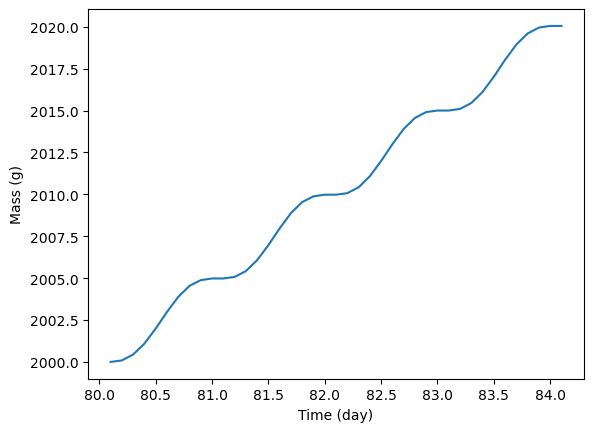

In [27]:
import matplotlib.pyplot as plt
plt.plot(data_v0[0], data_v0[1])
plt.xlabel(f'Time ({data_v0[0].units})')
plt.ylabel(f'Mass ({data_v0[1].units})')

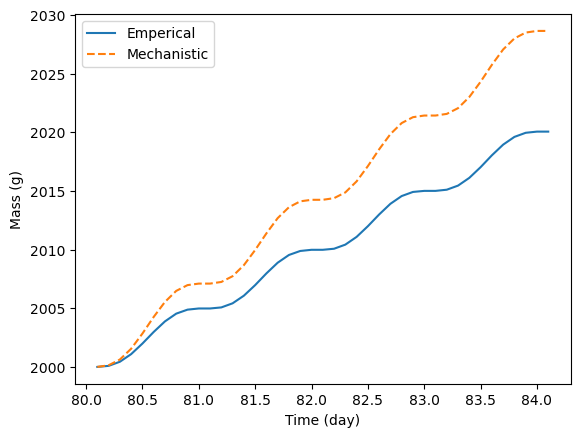

In [31]:
import matplotlib.pyplot as plt
ax = plt.plot(data_v0[0], data_v0[1], '-', data_v1[0], data_v1[1], '--')
plt.xlabel(f'Time ({data_v0[0].units})')
plt.ylabel(f'Mass ({data_v0[1].units})')
ax[0].set_label('Emperical')
ax[1].set_label('Mechanistic')
plt.legend()

In [32]:
tools.display_source('output/yield_v0.txt')

file: output/yield_v0.txt
# time	 mass
# day	g
# %g	%g
80.1	2000
80.2	2000.09
80.3	2000.44
80.4	2001.09
80.5	2001.99
80.6	2002.98
80.7	2003.88
80.8	2004.54
80.9	2004.88
81	2004.98
81.1	2004.98
81.2	2005.07
81.3	2005.42
81.4	2006.07
81.5	2006.97
81.6	2007.97
81.7	2008.88
81.8	2009.54
81.9	2009.88
82	2009.98
82.1	2009.98
82.2	2010.07
82.3	2010.42
82.4	2011.08
82.5	2011.99
82.6	2012.99
82.7	2013.9
82.8	2014.56
82.9	2014.91
83	2015
83.1	2015
83.2	2015.1
83.3	2015.45
83.4	2016.11
83.5	2017.02
83.6	2018.03
83.7	2018.94
83.8	2019.6
83.9	2019.95
84	2020.05
84.1	2020.05




In [33]:
tools.display_source('output/yield_v1.txt')

file: output/yield_v1.txt
# time	 mass
# day	g
# %g	%g
80.1	2000
80.2	2000.14
80.3	2000.63
80.4	2001.55
80.5	2002.84
80.6	2004.26
80.7	2005.54
80.8	2006.48
80.9	2006.97
81	2007.1
81.1	2007.1
81.2	2007.24
81.3	2007.73
81.4	2008.67
81.5	2009.96
81.6	2011.38
81.7	2012.68
81.8	2013.61
81.9	2014.11
82	2014.24
82.1	2014.24
82.2	2014.38
82.3	2014.87
82.4	2015.81
82.5	2017.11
82.6	2018.54
82.7	2019.84
82.8	2020.78
82.9	2021.28
83	2021.42
83.1	2021.42
83.2	2021.56
83.3	2022.05
83.4	2023
83.5	2024.3
83.6	2025.74
83.7	2027.05
83.8	2027.99
83.9	2028.49
84	2028.63
84.1	2028.63




In [34]:
tools.display_source('output/light.txt')

file: output/light.txt
# erg*(s**-1)
# %g
8.3854


